 # Notebook description

In this notebook analysis is made about the relation between delays and weather conditions

 Libraries import and loading enviroment variables

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import plotly.express as px
from dotenv import load_dotenv
from os import environ

In [2]:
dotenv_path = '../.env'
load_dotenv(dotenv_path)

True

In [3]:
username = environ.get('db_username')
password = environ.get('db_password')

host = environ.get('db_host')
database = environ.get('db_database')
port = environ.get('db_port')

Creating connection variables

In [4]:
url = URL.create(
    "postgresql",
    username=username,
    password=password,
    host=host,
    database=database,
)
engine = create_engine(url)

Creating function that downloads data from database into dataframe

In [5]:
def read_sql_table(tablename):
    return pd.read_sql(f'select * from {tablename}', engine)

Uploading flight dataframe from pickle file

In [6]:
flight_df = pd.read_pickle(r'..\data\processed\flight_df_01.pk1')

 # Adding aiport_list table to enviroment

Loading `airport_list` table

In [7]:
airport_list_df = read_sql_table('airport_list')
airport_list_df.tail()

,id,origin_airport_id,display_airport_name,origin_city_name,name
92,93,13198,Kansas City International,"Kansas City, MO","KANSAS CITY INTERNATIONAL AIRPORT, MO US"
93,94,10423,Austin - Bergstrom International,"Austin, TX","AUSTIN BERGSTROM INTERNATIONAL AIRPORT, TX US"
94,95,15370,Tulsa International,"Tulsa, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
95,96,13303,Miami International,"Miami, FL","MIAMI INTERNATIONAL AIRPORT, FL US"
96,97,10693,Myrtle Beach International,"Myrtle Beach, SC","NORTH MYRTLE BEACH, SC US"


Checking for duplicates

In [8]:
airport_list_df_is_duplicated = airport_list_df.duplicated(subset='origin_airport_id')
airport_list_df.loc[airport_list_df_is_duplicated]

,id,origin_airport_id,display_airport_name,origin_city_name,name


Deleting duplicates

In [9]:
airport_list_df_1 = airport_list_df.drop(columns = ['id', 'display_airport_name', 'name'])

Adding airport_list to flight_df using (origin aiport)

In [10]:
flight_df = flight_df.join(airport_list_df_1.set_index('origin_airport_id'), on = 'origin_airport_id', how = 'left')
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year,manufacture_year_agg,origin_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,NaN,2019,0,1,2005.0,"(2002, 2005]","Atlanta, GA"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,NaN,2019,0,1,2016.0,"(2014, 2017]","Atlanta, GA"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,10.0,0.0,3.0,2019,0,1,1998.0,"(1996, 1999]","Atlanta, GA"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,NaN,2019,0,1,1998.0,"(1996, 1999]","Atlanta, GA"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,NaN,2019,0,1,2001.0,"(1999, 2002]","Atlanta, GA"


Adding airport_list to flight_df using (destination aiport)

In [11]:
airport_list_df_2 = airport_list_df_1.copy()
airport_list_df_2.columns = ['dest_airport_id', 'destination_city_name']
flight_df = flight_df.join(airport_list_df_2.set_index('dest_airport_id'), on = 'dest_airport_id', how = 'left')
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,2019,0,1,2005.0,"(2002, 2005]","Atlanta, GA","Denver, CO"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,2019,0,1,2016.0,"(2014, 2017]","Atlanta, GA","Denver, CO"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,10.0,0.0,3.0,2019,0,1,1998.0,"(1996, 1999]","Atlanta, GA","Denver, CO"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,2019,0,1,1998.0,"(1996, 1999]","Atlanta, GA","Denver, CO"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,2019,0,1,2001.0,"(1999, 2002]","Atlanta, GA","Fort Lauderdale, FL"


 ## Analysis of flights and airports

Top origin airports

In [12]:
top_airports_origin_df = flight_df.loc[:,['origin_airport_id', 'id']]
top_airports_origin_df = top_airports_origin_df.groupby(
    'origin_airport_id'
).count().reset_index().sort_values('id', ascending = False)
top_airports_origin_df.head()

,origin_airport_id,id
1,10397,123162
28,13930,105437
20,12892,87849
8,11292,64525
21,12953,57708


Top destination airports

In [13]:
top_airports_destination_df = flight_df.loc[:,['dest_airport_id', 'id']]
top_airports_destination_df = top_airports_destination_df.groupby(
    'dest_airport_id'
).count().reset_index().sort_values('id', ascending = False)
top_airports_destination_df.head()

,dest_airport_id,id
1,10397,122945
29,13930,100333
21,12892,87776
9,11292,64602
22,12953,57686


Most popular routes

In [14]:
top_route_df = flight_df.loc[:,['origin_airport_id', 'dest_airport_id', 'id']]
#top_route_df['route'] = top_route_df['origin_airport_id'].astype(str) + '-' + top_route_df['dest_airport_id'].astype(str)
#top_route_df = top_route_df.drop(columns = ['origin_airport_id', 'dest_airport_id'])
top_route_df = top_route_df.groupby(['origin_airport_id', 'dest_airport_id']).count().sort_values('id', ascending = False)
top_route_df.head()

,,id
origin_airport_id,dest_airport_id,
13930,12953,14219
12953,13930,14203
12892,14771,14096
14771,12892,14088
12892,12478,12797


Routes with the least delay ratio

In [15]:
least_route_delays_df = flight_df.loc[:,['origin_airport_id', 'dest_airport_id', 'is_delayed']]
least_route_delays_df = least_route_delays_df.groupby(['origin_airport_id', 'dest_airport_id']).mean().sort_values('is_delayed', ascending = True)
least_route_delays_df['is_delayed'] = round(least_route_delays_df['is_delayed'] * 100, 2)
least_route_delays_df.head()

,,is_delayed
origin_airport_id,dest_airport_id,
12173,12982,5.12
12402,12173,5.22
12173,12402,5.24
12758,12173,5.34
12982,12173,5.41


Routes with the biggest delay ratio

In [16]:
top_route_delays_df = flight_df.loc[:,['origin_airport_id', 'dest_airport_id', 'is_delayed']]
top_route_delays_df = top_route_delays_df.groupby(['origin_airport_id', 'dest_airport_id']).mean().sort_values('is_delayed', ascending = False)
top_route_delays_df['is_delayed'] = round(top_route_delays_df['is_delayed'] * 100, 2)
top_route_delays_df.head()

,,is_delayed
origin_airport_id,dest_airport_id,
13204,11618,33.52
11292,14771,32.05
10397,11618,31.19
11618,10721,29.34
13930,11618,28.78


 # Adding weather conditions

Loading `airport_weather`

In [17]:
airport_weather_df = read_sql_table('airport_weather')
airport_weather_df.head(1)

,id,station,name,date,awnd,pgtm,prcp,snow,snwd,tavg,...,wt09,wesd,wt10,psun,tsun,sn32,sx32,tobs,wt11,wt18
0,1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,4.7,NaN,0.14,0.0,0.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


Deleting not needed columns

In [18]:
airport_weather_df = airport_weather_df.loc[:,['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']]
airport_weather_df.head()

,station,name,date,prcp,snow,snwd,tmax,awnd
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42


Merging airport_list and airport_weather

In [19]:
airport_weather_df = airport_weather_df.merge(airport_list_df[['name', 'origin_airport_id']], on='name', how='inner')

In [20]:
airport_weather_df.head()

,station,name,date,prcp,snow,snwd,tmax,awnd,origin_airport_id
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70,10397
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92,10397
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37,10397
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08,10397
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42,10397


 ## Merging `airport_weather_df` and `flight_df`

Converting column `date` to `DATETIME` in `airport_weather_df`

In [21]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])

In [22]:
flight_df = flight_df.rename(columns = {'day_of_month': 'day'})
flight_df.head(1)

,id,month,day,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,2019,0,1,2005.0,"(2002, 2005]","Atlanta, GA","Denver, CO"


Creating 'date' column in flight_df (in DATETIME format)

In [23]:
flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])
flight_df.head(1)

,id,month,day,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name,date
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,2019,0,1,2005.0,"(2002, 2005]","Atlanta, GA","Denver, CO",2019-01-20


Merging `airport_weather_df` and `flight_df`

In [24]:
flight_df = flight_df.merge(
    airport_weather_df[['date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd', 'origin_airport_id']], 
    on=['origin_airport_id', 'date'], 
    how='left'
)
flight_df.head(1)

,id,month,day,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name,date,prcp,snow,snwd,tmax,awnd
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,2005.0,"(2002, 2005]","Atlanta, GA","Denver, CO",2019-01-20,0.0,0.0,0.0,53.0,20.36


# Testing hypothesis that lower temperature have an impact on flight delays

 ## Analysing `tmax` column and deleting outliers using interquartile range
 

In [25]:
q1 = flight_df['tmax'].quantile(0.25) 
q3 = flight_df['tmax'].quantile(0.75)
iqr = q3 - q1

low_boundary = (q1 - 1.5 * iqr)
upp_boundary = (q3 + 1.5 * iqr)
num_of_outliers_L = (flight_df['tmax'] < low_boundary).sum()
num_of_outliers_U = (flight_df['tmax'] > upp_boundary).sum()
outliers_15iqr = {
    'lower_boundary':low_boundary, 
    'upper_boundary':upp_boundary,
    'num_of_outliers_L':num_of_outliers_L, 
    'num_of_outliers_U':num_of_outliers_U
}
outliers_15iqr

{'lower_boundary': 21.5,
 'upper_boundary': 121.5,
 'num_of_outliers_L': 6840,
 'num_of_outliers_U': 0}

In [26]:
flight_df_without_outliers = flight_df.copy()

flight_df_without_outliers = flight_df_without_outliers.loc[
    (flight_df_without_outliers['tmax'] >= low_boundary) 
]  #ta metoda od razu wyrzuca z ramki wartości NA

flight_df_without_outliers = flight_df_without_outliers.loc[:,['tmax', 'is_delayed']]

Grouping delays ratio by tmax column

In [27]:
flight_df_without_outliers_grouped = flight_df_without_outliers.groupby('tmax').mean()
flight_df_without_outliers_grouped['is_delayed'] = round(flight_df_without_outliers_grouped['is_delayed'] * 100, 2)
flight_df_without_outliers_grouped.sort_values('is_delayed', ascending = False)

,is_delayed
tmax,
28.0,34.25
25.0,30.28
22.0,29.57
34.0,29.41
23.0,28.97
...,...
54.0,16.62
112.0,16.46
79.0,16.38


Creating lineplot of delay ratio in relation to max temperature

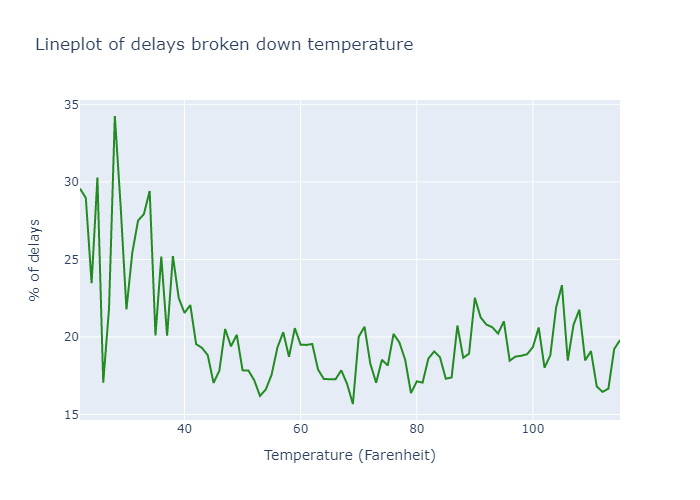

In [28]:
fig_temp_delay = px.line(flight_df_without_outliers_grouped.reset_index(),
                      x='tmax',
                      y = 'is_delayed',
                      title='Lineplot of delays broken down temperature',
                      color_discrete_sequence = ['forestgreen'])
fig_temp_delay.update_layout(xaxis_title="Temperature (Farenheit)", yaxis_title="% of delays")
#fig_temp_delay.update_xaxes(dtick = 2, tickangle=45)

fig_temp_delay.show('png')

### In summary, growth in temperature has a slight influence on delays ratio. There is a considerable decrease in delays when the maximal temperature is >40 degrees. If the max temperature is over 40 degrees Farenheit the delay ratio oscillates around 18-20%